

<center> <img src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="300"/> </center>

# <center>Arize Prompt Experimentation</center>

This guide demonstrates how to use Arize for logging and analyzing prompt iteration experiments with your LLM. We're going to build a simple prompt experimentation pipeline that generates outputs using different variations of a base prompt. The generated outputs will be logged to an Arize dataset along with the corresponding prompt used. Arize makes it easy to track and compare results from prompt iteration experiments, allowing you to identify which prompt variations yield the best performance. You can read more about experiment tracking with Arize here.
In this tutorial, you will:

*   Set up an Arize dataset to log the prompts and generated outputs from our experiments

*   Create a base prompt and define a set of variations to experiment with

*   Implement a script that iterates through the prompt variations, generates outputs using an LLM, and logs each prompt-output pair to the Arize dataset

*   Analyze the logged data in Arize to compare results across prompt variations and identify the best performing prompts

By leveraging Arize for experiment tracking, you'll be able to systematically test different prompt variations at scale and use the logged data to inform your prompt engineering process. Let's get started!

ℹ️ This notebook requires:
- An OpenAI API key
- An Arize Space ID & Developer Key (explained below)


# Step 1: Setup Config

Copy the Arize developer API Key and Space ID from the Datasets page (shown below) to the variables in the cell below.

<center><img src="https://storage.googleapis.com/arize-assets/fixtures/dataset_api_key.png" width="700"></center>




In [ ]:
from uuid import uuid1
#FROM Datasets UI #
space_id = ""
developer_key = ""
###################
dataset_name = "docs-qa-new-" + str(uuid1())[:5]


Install dependencies

In [ ]:
!pip install 'arize[Datasets]' openai datasets pyarrow pydantic nest_asyncio --quiet

In [ ]:
!pip install 'arize-phoenix[evals]' --quiet
import phoenix as px
from phoenix.trace import DocumentEvaluations, SpanEvaluations
from phoenix.trace.openai import OpenAIInstrumentor


Let's make sure we can run async code in the notebook.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

Lastly, let's make sure we have our openai API key set up.

In [ ]:
import os
from getpass import getpass

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Enter your OpenAI API key: ")

## Step 2: Download Data
This is Q&A RAG on Arize docs, Hallucination detected spans

In [ ]:
import requests
import pandas as pd

url = "https://storage.googleapis.com/arize-assets/examples/dataset_10.parquet"
local_filename = 'dataset_10.parquet'

# Download the file
with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

In [ ]:
result_df = pd.read_parquet('dataset_10.parquet')


In [ ]:
df_loaded = result_df[0:4]

## Step 3: Implement Prompt Change



In [ ]:
len(df_loaded)

Awesome, let's try running the query and see if we get the expected results.

## Evaluation

Evaluation consists of three parts:
1. data
2. task
3. scores

We'll start with data.

We are going to use the original outputs as "expected" outputs for the first test.
Let's store the data above as a versioned dataset in Arize.

In [ ]:
import json
df_loaded.loc[:,'attributes.llm.prompt_template.variables'] = df_loaded['attributes.llm.prompt_template.variables'].apply(lambda x: json.dumps(x))
json.loads(df_loaded['attributes.llm.prompt_template.variables'][0])['query_str']

In [ ]:
test_df= df_loaded[['name', 'span_kind', 'parent_id', 'start_time', 'end_time',
       'status_code', 'status_message', 'events', 'context.span_id',
       'context.trace_id', 'attributes.embedding.model_name',
       'attributes.openinference.span.kind', 'attributes.embedding.embeddings',
       'attributes.input.value', 'attributes.retrieval.documents',
       'attributes.llm.token_count.prompt', 'attributes.llm.input_messages',
       'attributes.llm.prompt_template.template',
       'attributes.llm.invocation_parameters',
       'attributes.llm.output_messages', 'attributes.llm.model_name',
       'attributes.llm.token_count.total', 'attributes.output.value',
       'attributes.llm.prompt_template.variables',
       'attributes.llm.token_count.completion']]

In [ ]:
from arize.experimental.datasets import ArizeDatasetsClient
from arize.experimental.datasets.utils.constants import GENERATIVE

import pandas as pd
arize_client = ArizeDatasetsClient(developer_key=developer_key)
# Create a dataset from a DataFrame add your own data here
df = pd.DataFrame(test_df)
dataset_id = arize_client.create_dataset(space_id=space_id, dataset_name=dataset_name, dataset_type=GENERATIVE, data=df)
dataset_name

Let's now pull down the dataset from Arize in this environment, and test load a row

In [ ]:
dataset = arize_client.get_dataset(space_id=space_id, dataset_id=dataset_id)

In [ ]:
json.loads(dataset['attributes.llm.prompt_template.variables'][0])['query_str']


You can also check the entire dataset dataframe

In [ ]:
dataset

# Step 4: Define Evaluators

In [ ]:
#Arize types of phoenix classes
from arize.experimental.datasets.experiments.evaluators.base import (
    EvaluationResult,
    Evaluator
)

from arize.experimental.datasets.experiments.types import (
    Example,
    ExperimentRun,
)

from arize.experimental.datasets.experiments.functions import _bind_task_signature,_validate_task_signature,_dataframe_to_examples

In [ ]:
import nest_asyncio
from phoenix.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    HALLUCINATION_PROMPT_RAILS_MAP, QA_PROMPT_RAILS_MAP,
     HALLUCINATION_SPAN_PROMPT_TEMPLATE,
    QA_PROMPT_RAILS_MAP,
    QA_PROMPT_TEMPLATE,
    OpenAIModel,
    llm_classify,
)

We'll define the scores for the evals. We'll use the following LLM scoring:

In [ ]:
class Hallucination(Evaluator):
    annotator_kind = "CODE"
    name = "factual_hallucination"

    def evaluate(self, output, dataset_row, **kwargs) -> EvaluationResult:
        expected_output = dataset_row['attributes.output.value']
        input = json.loads(dataset_row['attributes.llm.prompt_template.variables'])
        query_str = input['query_str']
        context_str = input['context_str']
        ################################
        ####### Expected EVAL #####
        df_in = pd.DataFrame({"output": output, "input": query_str, "reference":context_str}, index=[0])
        rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
        expect_df = llm_classify(
            dataframe=df_in,
            template= HALLUCINATION_PROMPT_TEMPLATE,
            model=OpenAIModel(model="gpt-4-turbo-preview"),
            rails=rails,
            provide_explanation=True,
            run_sync=True
        )
        label = expect_df['label'][0]
        score = 1 if rails and label == rails[1] else 0 #Choose the 0 item in rails as the correct "1" label
        explanation = expect_df['explanation'][0]
        return EvaluationResult(score=score, label=label, explanation=explanation)

    async def async_evaluate(self, _: Example, exp_run: ExperimentRun) -> EvaluationResult:
        return self.evaluate(_, exp_run)



class QA(Evaluator):
    annotator_kind = "CODE"
    name = "question_and_answer"

    def evaluate(self, output, dataset_row, **kwargs) -> EvaluationResult:
        expected_output = dataset_row['attributes.output.value']
        input = json.loads(dataset_row['attributes.llm.prompt_template.variables'])
        query_str = input['query_str']
        context_str = input['context_str']
        ################################
        ####### Expected EVAL #####
        df_in = pd.DataFrame({"output": output, "input": query_str, "reference":context_str}, index=[0])
        rails = list(QA_PROMPT_RAILS_MAP.values())
        expect_df = llm_classify(
            dataframe=df_in,
            template= QA_PROMPT_TEMPLATE,
            model=OpenAIModel(model="gpt-4-turbo-preview"),
            rails=rails,
            provide_explanation=True,
            run_sync=True
        )
        label = expect_df['label'][0]
        score = 1 if rails and label == rails[0] else 0 #Choose the 0 item in rails as the correct "1" label
        explanation = expect_df['explanation'][0]
        return EvaluationResult(score=score, label=label, explanation=explanation)

    async def async_evaluate(self, _: Example, exp_run: ExperimentRun) -> EvaluationResult:
        return self.evaluate(_, exp_run)


Now let's define a task and run the evaluation experiment.

In [ ]:
new_template = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer:
"""
TASK_MODEL = "gpt-4-turbo-preview"

In [ ]:
import os
from textwrap import dedent
import json

import openai
from openai import OpenAI

client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  # this is also the default, it can be omitted
)

def run_prompt(example)-> str:
    json_str = example.dataset_row['attributes.llm.prompt_template.variables']
    prompt_vars = json.loads(example.dataset_row['attributes.llm.prompt_template.variables'])
    full_prompt = new_template.format(**prompt_vars)
    response = client.chat.completions.create(
        model=TASK_MODEL,
        temperature=0.1,

        messages=[
            {
                "role": "system",
                "content": " ",
            },
            {
                "role": "user",
                "content": full_prompt,
            },
        ],
    )
    return response.choices[0].message.content

In [ ]:
# Define the task to run
def prompt_gen_task(example) -> str:
    print(example.dataset_row.keys())
    return run_prompt(example)

Now lets check the dataset

# Step 5: Run Experiment

Run experiment 1 and log results to Arize

In [ ]:
experiment = arize_client.run_experiment( space_id=space_id,
    dataset_id=dataset_id, task=prompt_gen_task, evaluators=[Hallucination(), QA() ], experiment_name="gpt-4_original_prompt")

Run experiment 2 and log results to Arize

In [ ]:
##TASK GLOBAL VARIABLES##
TASK_MODEL = "gpt-4-turbo-preview"

new_template = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If the context does not answer the question, say you don't know and you
should contact support@arize.com
Query: {query_str}
Answer:
"""

In [ ]:
experiment = arize_client.run_experiment( space_id=space_id,
    dataset_id=dataset_id, task=prompt_gen_task, evaluators=[Hallucination(), QA() ], experiment_name="gpt-4_new_prompt")

Run experiment 3 and log results to Arize

In [ ]:
#Template that fixes the I don't know
TASK_MODEL = "gpt-3.5-turbo-0125"

updated_template = """
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
If the context does not answer the question, say you don't know and you
should contact support@arize.com
Query: {query_str}
Answer:
"""

In [ ]:
experiment = arize_client.run_experiment( space_id=space_id,
    dataset_id=dataset_id, task=prompt_gen_task, evaluators=[Hallucination(), QA() ], experiment_name="gpt-3.5_new_prompt")

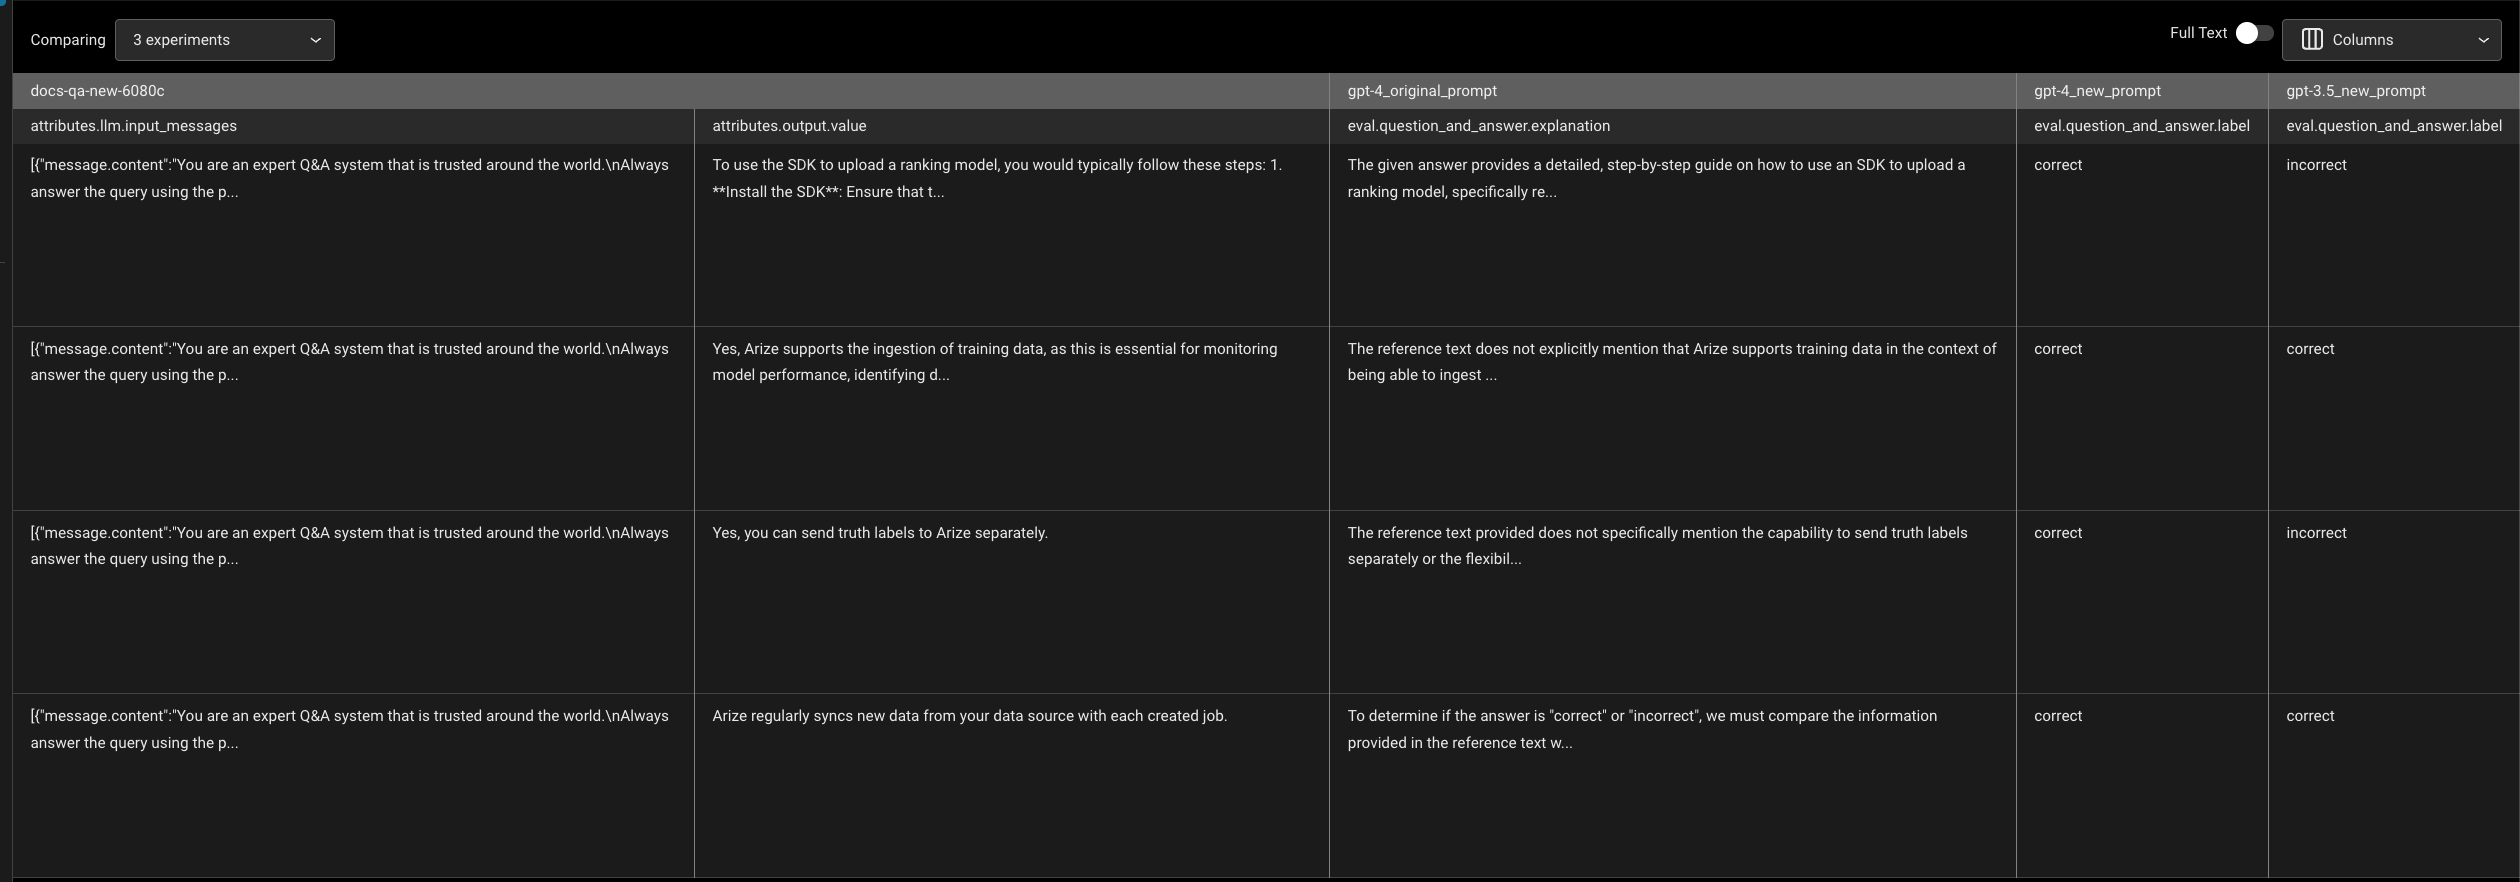